In [24]:
import pandas as pd
import json

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score, f1_score
import transformers
from transformers import BertForTokenClassification, AdamW, BertModel
from seqeval.metrics import f1_score, accuracy_score

from tqdm import tqdm, trange
import numpy as np

import glob
import random

In [25]:
pwd

'/data/mmortgage/NERAPI'

In [26]:
# df = pd.read_csv('./ner.csv')
# df.head(2)

In [27]:
# df[df['PDF Name']==9500]

In [28]:
# df.columns

In [29]:
# for i,row in df.iterrows():
#     filename = './data/'+str(row['PDF Name'])+'.txt'
#     with open(filename, 'w') as f:
#         f.write(row['text'])

In [30]:
entities = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'PAD']

In [31]:
def get_annotations(file_loc):
    words = []
    labels = []
    for conll in list(glob.glob(file_loc)):

        with open(conll) as file:
            lines=file.read().splitlines()

        tempWords = []
        tempLabels = []
        for line in lines:

            if line!='':
                if line == '-DOCSTART- -X- O':
                    continue
                else:
                    w,l = line.split('-X- _')
                    tempWords.append(w.strip())
                    tempLabels.append(l.strip())
            else:
                words.append(tempWords)
                labels.append(tempLabels)
                tempWords = []
                tempLabels = []
                
    return words,labels

In [32]:
words, labels = get_annotations('/data/mmortgage/amal_workspace/BankStatement_Failed/NER_ANNOTATIONS/tt/*.conll')

In [33]:
len(words)

342

In [34]:
len(labels)

342

In [35]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [36]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [37]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(words, labels)
]

In [38]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [39]:
MAX_LEN = 300
bs = 4
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [40]:
tags = pad_sequences([[entities.index(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=entities.index("PAD"), padding="post",
                     dtype="long", truncating="post")

In [41]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [42]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2000, test_size=0.2)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2000, test_size=0.2)

In [43]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [44]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [45]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(entities),
    output_attentions = False,
    output_hidden_states = False
)
model.cuda()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [46]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

/data/mmortgage/NERAPI/NER/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [47]:
from transformers import get_linear_schedule_with_warmup

epochs = 30
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=207,
    num_training_steps=total_steps
)
len(train_dataloader),epochs,total_steps

(69, 30, 2070)

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [49]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []
accuracy, f1 = [], []
tag_values = entities

for epoch in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask,  labels=b_labels)
        #print(outputs)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    acc = accuracy_score(pred_tags, valid_tags)
    #f_score = f1_score(pred_tags, valid_tags, average='weighted')
    f_score = f1_score([pred_tags], [valid_tags])
    accuracy.append(acc)
    f1.append(f_score)
    print("Validation Accuracy: {}".format(acc))
    print("Validation F1-Score: {}".format(f_score))
    torch.save(model.state_dict(), 
               f'/mnt/BERT_NER/BERT_epoch{epoch}.model')
    print()

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Average train loss: 1.0400255223115284
Validation loss: 0.544763273662991
Validation Accuracy: 0.8284256559766764
Validation F1-Score: 0.0031080031080031076


Epoch:   3%|▎         | 1/30 [00:11<05:47, 11.99s/it]


Average train loss: 0.41660473452530045
Validation loss: 0.35054604709148407
Validation Accuracy: 0.8854227405247813
Validation F1-Score: 0.16097278517660682


Epoch:   7%|▋         | 2/30 [00:23<05:35, 11.97s/it]


Average train loss: 0.27042285050602927
Validation loss: 0.28279565274715424
Validation Accuracy: 0.913022351797862
Validation F1-Score: 0.43868921775898523


Epoch:  10%|█         | 3/30 [00:35<05:23, 11.97s/it]


Average train loss: 0.17788994409467862
Validation loss: 0.229332085698843
Validation Accuracy: 0.9354227405247814
Validation F1-Score: 0.5715756951596294


/data/mmortgage/NERAPI/NER/lib/python3.8/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PAD seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
Epoch:  13%|█▎        | 4/30 [00:47<05:11, 11.97s/it]


Average train loss: 0.12774686329066753
Validation loss: 0.2356029844118489
Validation Accuracy: 0.9310009718172984
Validation F1-Score: 0.6583493282149712


Epoch:  17%|█▋        | 5/30 [00:59<04:59, 11.98s/it]


Average train loss: 0.10095800748229891
Validation loss: 0.30450691199964947
Validation Accuracy: 0.917687074829932
Validation F1-Score: 0.6394052044609665


Epoch:  20%|██        | 6/30 [01:11<04:47, 11.97s/it]


Average train loss: 0.08337281007940571
Validation loss: 0.24948718812730578
Validation Accuracy: 0.9249757045675413
Validation F1-Score: 0.6984126984126985


Epoch:  23%|██▎       | 7/30 [01:23<04:35, 11.97s/it]


Average train loss: 0.07533885954298834
Validation loss: 0.2416105754673481
Validation Accuracy: 0.9417395529640428
Validation F1-Score: 0.7221451687471105


Epoch:  27%|██▋       | 8/30 [01:35<04:24, 12.00s/it]


Average train loss: 0.0619850164225352
Validation loss: 0.25947315825356376
Validation Accuracy: 0.9422254616132167
Validation F1-Score: 0.72790813779331


Epoch:  30%|███       | 9/30 [01:47<04:11, 11.99s/it]


Average train loss: 0.05976248413756274
Validation loss: 0.2830596996678246
Validation Accuracy: 0.9409620991253644
Validation F1-Score: 0.7177734375000001


Epoch:  33%|███▎      | 10/30 [01:59<03:59, 11.98s/it]


Average train loss: 0.05001533272392724
Validation loss: 0.2698328842719396
Validation Accuracy: 0.9425170068027211
Validation F1-Score: 0.712871287128713


Epoch:  37%|███▋      | 11/30 [02:11<03:47, 11.98s/it]


Average train loss: 0.04312204127199948
Validation loss: 0.31354282713598675
Validation Accuracy: 0.9438289601554908
Validation F1-Score: 0.741506646971935


Epoch:  40%|████      | 12/30 [02:23<03:35, 11.97s/it]


Average train loss: 0.040294162534258285
Validation loss: 0.28314095983902615
Validation Accuracy: 0.9472789115646258
Validation F1-Score: 0.7494231656668204


Epoch:  43%|████▎     | 13/30 [02:35<03:23, 11.97s/it]


Average train loss: 0.037516155347659966
Validation loss: 0.3093346080018414
Validation Accuracy: 0.9438775510204082
Validation F1-Score: 0.7372296364473079


Epoch:  47%|████▋     | 14/30 [02:47<03:11, 11.97s/it]


Average train loss: 0.029306033194281052
Validation loss: 0.3282324688302146
Validation Accuracy: 0.9448007774538387
Validation F1-Score: 0.748750567923671


Epoch:  50%|█████     | 15/30 [02:59<02:59, 11.97s/it]


Average train loss: 0.028320059596992814
Validation loss: 0.33144043054845596
Validation Accuracy: 0.9450923226433431
Validation F1-Score: 0.7502410800385727


Epoch:  53%|█████▎    | 16/30 [03:11<02:47, 11.97s/it]


Average train loss: 0.024040062053034595
Validation loss: 0.3358355801966455
Validation Accuracy: 0.951846452866861
Validation F1-Score: 0.7584849975405803


Epoch:  57%|█████▋    | 17/30 [03:23<02:35, 11.97s/it]


Average train loss: 0.02005547185367702
Validation loss: 0.36127063714795643
Validation Accuracy: 0.9462585034013605
Validation F1-Score: 0.7458937198067632


Epoch:  60%|██████    | 18/30 [03:35<02:23, 11.98s/it]


Average train loss: 0.0179196085006444
Validation loss: 0.3331027138564322
Validation Accuracy: 0.9495140913508261
Validation F1-Score: 0.7628865979381443


Epoch:  63%|██████▎   | 19/30 [03:47<02:11, 11.97s/it]


Average train loss: 0.014957587545960332
Validation loss: 0.3483405080106523
Validation Accuracy: 0.9515063168124392
Validation F1-Score: 0.7598039215686274


Epoch:  67%|██████▋   | 20/30 [03:59<01:59, 11.98s/it]


Average train loss: 0.014791682089233527
Validation loss: 0.35952820877234143
Validation Accuracy: 0.9500971817298348
Validation F1-Score: 0.7655139744197063


Epoch:  70%|███████   | 21/30 [04:11<01:47, 11.98s/it]


Average train loss: 0.012586583590060742
Validation loss: 0.35267413697308964
Validation Accuracy: 0.9504373177842566
Validation F1-Score: 0.7499999999999999


Epoch:  73%|███████▎  | 22/30 [04:23<01:35, 11.99s/it]


Average train loss: 0.011186890341206521
Validation loss: 0.38007649903496105
Validation Accuracy: 0.9508260447035958
Validation F1-Score: 0.7650485436893203


Epoch:  77%|███████▋  | 23/30 [04:35<01:24, 12.03s/it]


Average train loss: 0.009846676359091467
Validation loss: 0.37711221766140723
Validation Accuracy: 0.9504859086491739
Validation F1-Score: 0.754735308402137


Epoch:  80%|████████  | 24/30 [04:47<01:12, 12.07s/it]


Average train loss: 0.01005733186510675
Validation loss: 0.39881663935052025
Validation Accuracy: 0.9467444120505345
Validation F1-Score: 0.7515439429928741


Epoch:  83%|████████▎ | 25/30 [04:59<01:00, 12.04s/it]


Average train loss: 0.00834281877040917
Validation loss: 0.39517013024952674
Validation Accuracy: 0.9474732750242955
Validation F1-Score: 0.7535680304471932


Epoch:  87%|████████▋ | 26/30 [05:11<00:48, 12.04s/it]


Average train loss: 0.0073955441277602394
Validation loss: 0.40577495925956303
Validation Accuracy: 0.9470359572400389
Validation F1-Score: 0.7531975367124587


Epoch:  90%|█████████ | 27/30 [05:23<00:36, 12.04s/it]


Average train loss: 0.006465382589722403
Validation loss: 0.4036489621632629
Validation Accuracy: 0.9471817298347911
Validation F1-Score: 0.754985754985755


Epoch:  93%|█████████▎| 28/30 [05:35<00:24, 12.02s/it]


Average train loss: 0.00574100725445559
Validation loss: 0.40181637596752906
Validation Accuracy: 0.9483965014577259
Validation F1-Score: 0.7559808612440191


Epoch:  97%|█████████▋| 29/30 [05:47<00:12, 12.00s/it]


Average train loss: 0.005651367244064349
Validation loss: 0.4042012476258808
Validation Accuracy: 0.9478134110787172
Validation F1-Score: 0.7523900573613767


Epoch: 100%|██████████| 30/30 [05:59<00:00, 11.99s/it]

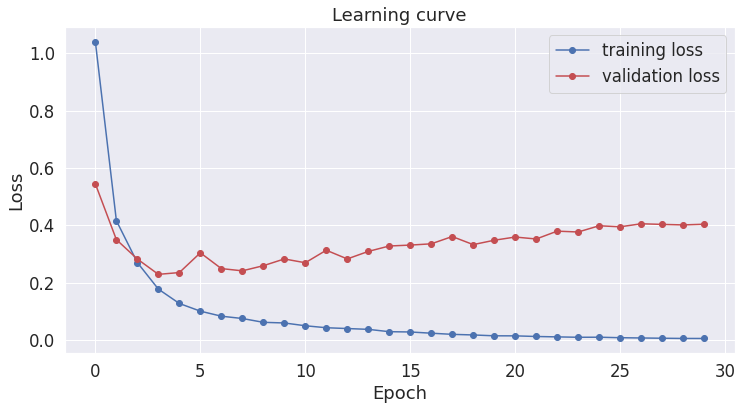

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


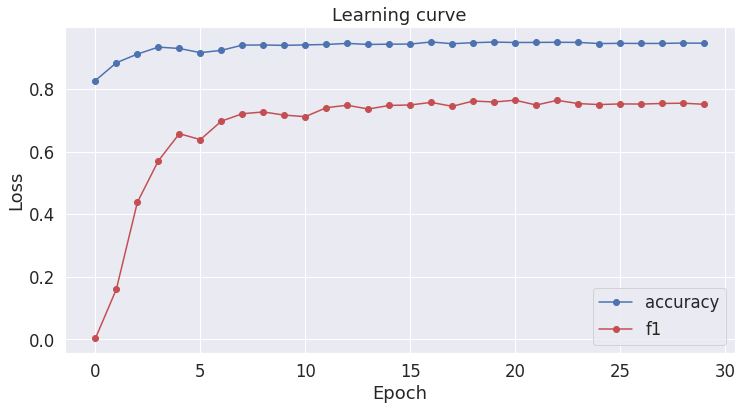

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(accuracy, 'b-o', label="accuracy")
plt.plot(f1, 'r-o', label="f1")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


### TEST

In [84]:
words, labels = get_annotations('/data/mmortgage/amal_workspace/BankStatement_Failed/NER_ANNOTATIONS/*.conll')
len(words)

56

In [85]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(entities),
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [86]:
model.load_state_dict(torch.load("/mnt/BERT_NER/BERT_epoch10.model", map_location=torch.device('cuda')))
model.cuda()
model.eval()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [87]:
tokenized_texts_and_labels = [
        tokenize_and_preserve_labels(sent, labs)
        for sent, labs in zip(words, labels)
    ]
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
gt_labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [88]:
MAX_LEN = 300
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")
tags = pad_sequences([[entities.index(l) for l in lab] for lab in gt_labels],
                     maxlen=MAX_LEN, value=entities.index("PAD"), padding="post",
                     dtype="long", truncating="post")

In [89]:
accuracy = 0
f1 = 0

for ids,tag in zip(input_ids, tags):
    ids = torch.tensor([ids]).cuda()

    with torch.no_grad():
         output = model(ids)
    logits = output['logits'].detach().cpu().numpy()
    predictions= [list(p) for p in np.argmax(logits, axis=2)]

    #predictions = np.array(predictions[0], dtype=np.uint8)
    #tag = np.array(tag, dtype=np.uint8)
    predictions = [[entities[pred] for pred in predictions[0]]]
    tag = [[entities[t] for t in tag]]
    
    accuracy+=accuracy_score(tag, predictions)
    f1+=f1_score(tag, predictions, average='weighted')

In [90]:
len(tokenized_texts)

56

In [91]:
print("Test Accuracy: {}".format(accuracy/len(tokenized_texts)))
print("Test F1-Score: {}".format(f1/len(tokenized_texts)))

Test Accuracy: 0.9592261904761906
Test F1-Score: 0.7688295302241571


In [118]:
test_sentence = """
BANK OF AMERICA Preferred Rewards BANK OF AMERICA P.O. Box 15284 Wilmington, DE 19850 Customer service information 1.888.888.RWDS (1.888.888.7937) En EspaÃ±ol: 1.800.688.6086 ERIK M LITTLE 4253 CORINTH CHURCH RD LAKE PARK, GA 31636-2923 bankofamerica.com Bank of America, N.A. P.O. Box 25118 Tampa, FL 33622-5118 Your Regular Checking Preferred Rewards Platinum for July 16, 2022 to August 17, 2022 Account number: 3340 2555 6556 ERIK M LITTLE ATM and debit card subtractions -0.00 Other subtractions -1,470.00 Checks -0.00 Service fees -0.00 $126.78 Ending balance on August 17, 2022 Do you follow us on social media? Connect with us on Facebook and Twitter for timely information and to learn more about how to reach your financial goals. f When you use the QRC feature certain information is collected from your mobile device for business purposes. SSM-05-22-0100ÄŒ | 4718133 Page 1 of 4 CYCLE: 10 SPEC: E IMAGE: I BC: GA PULL: B DELIVERY: E TYPE: Account summary $392.14 Beginning balance on July 16, 2022 Deposits and other additions 1,204.64
"""

In [119]:
tokenized_sentence = tokenizer.encode(test_sentence, add_special_tokens=False)
input_ids = torch.tensor([tokenized_sentence[:300]]).cuda()

In [120]:
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

In [121]:
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

In [122]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

B-ORG	BANK
I-ORG	OF
I-ORG	AMERICA
O	Preferred
O	Rewards
B-ORG	BANK
I-ORG	OF
I-ORG	AMERICA
O	P
O	.
O	O
O	.
O	Box
O	15284
O	Wilmington
O	,
O	DE
O	19850
O	Customer
O	service
O	information
O	1
O	.
O	888
O	.
O	888
O	.
O	RWDS
O	(
O	1
O	.
O	888
O	.
O	888
O	.
O	7937
O	)
O	En
O	[UNK]
O	:
O	1
O	.
O	800
O	.
O	688
O	.
O	6086
B-PER	ERIK
I-PER	M
I-PER	LITTLE
B-LOC	4253
I-LOC	CORINTH
I-LOC	CHURCH
I-LOC	RD
I-LOC	LAKE
I-LOC	PARK
I-LOC	,
I-LOC	GA
I-LOC	31636
I-LOC	-
I-LOC	2923
O	bankofamerica
O	.
O	com
O	Bank
O	of
O	America
O	,
O	N
O	.
O	A
O	.
O	P
O	.
O	O
O	.
O	Box
O	25118
O	Tampa
O	,
O	FL
O	33622
O	-
O	5118
O	Your
O	Regular
O	Checking
O	Preferred
O	Rewards
O	Platinum
O	for
O	July
O	16
O	,
O	2022
O	to
O	August
O	17
O	,
O	2022
O	Account
O	number
O	:
O	3340
O	2555
O	6556
B-PER	ERIK
I-PER	M
I-PER	LITTLE
O	ATM
O	and
O	debit
O	card
O	subtractions
O	-
O	0
O	.
O	00
O	Other
O	subtractions
O	-
O	1
O	,
O	470
O	.
O	00
O	Checks
O	-
O	0
O	.
O	00
O	Service
O	fees
O	-
O	0
O	.
O	00
O	$
O	126
O	.
O	78
O	Ending
O	balance

In [43]:
d = {"BPER":[], "ORG": [], "LOC":[]}
for i, (token, label) in enumerate(zip(new_tokens, new_labels)):
    if label is "B-ORG":
        e = token
        i+=1
        while new_labels[i] is "I-ORG":
            e = e+" "+new_tokens[i]
            i+=1
            
        d["ORG"].append(e)
        continue
    
        

<>:3: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:3: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_24207/1153098304.py:3: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if label is "B-ORG":
/tmp/ipykernel_24207/1153098304.py:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
  while new_labels[i] is "I-ORG":


In [272]:
new_labels

['B-ORG',
 'I-ORG',
 'I-ORG',
 'O',
 'O',
 'B-ORG',
 'I-ORG',
 'I-ORG',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-PER',
 'I-PER',
 'I-PER',
 'B-LOC',
 'I-LOC',
 'I-LOC',
 'I-LOC',
 'I-LOC',
 'I-LOC',
 'I-LOC',
 'I-LOC',
 'I-LOC',
 'I-LOC',
 'I-LOC',
 'O',
 'O',
 'O',
 'B-ORG',
 'I-ORG',
 'I-ORG',
 'I-ORG',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-PER',
 'I-PER',
 'I-PER',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O'